In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import h5py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [129]:
rate = np.load('M1_firingrates.npy')
count = np.array(rate / 200.) # todo: send counts in int, not rates

pos_1kHz = np.load('joystick_position.npy')
pos = pos_1kHz[:,::5] # downsample to 200Hz, remove 1 sample
# convolve pos with a gaussian kernel
kernel = np.exp(-np.linspace(-2,2,10)**2/2)
kernel /= np.sum(kernel)
# convolve kernel with pos along the 1st axis
pos_smooth = np.zeros_like(pos)
for i in range(pos.shape[0]):
    for j in range(pos.shape[-1]):
        pos_smooth[i,:,j] = np.convolve(np.concatenate([pos[i,:,j],pos[i,::-1,j]]), kernel, mode='same')[:pos.shape[1]]
        
pos = pos[:,1:]
vel = np.diff(pos_smooth, axis=1) # velocity [pos]/s

start_bin = 50 # too much data before movement, which does not really aid training. Cutting for now to speed things up

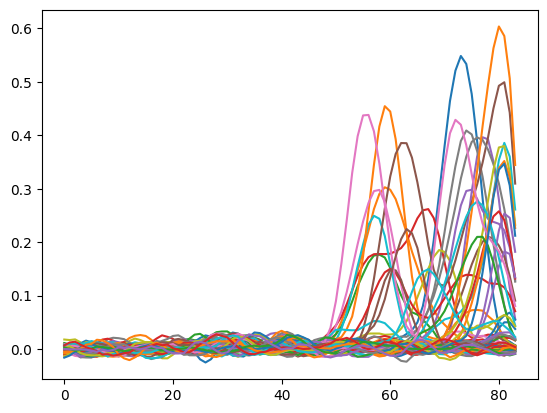

In [87]:
for p,v in zip(pos,vel):
    # plt.plot(*p.T)
    # plt.plot(p[start_bin:,1])
    plt.plot(v[start_bin:,0])

In [88]:
def get_data_fold(cv, FOLDS=5, start_bin=50):
    # order = np.random.permutation(count.shape[0])
    order = np.arange(count.shape[0])
    train_mask = order % FOLDS != cv
    valid_mask = order % FOLDS == cv
    train_data = count[train_mask][:,start_bin:]
    valid_data = count[valid_mask][:,start_bin:]
    train_behaviours = vel[train_mask][:,start_bin:]
    valid_behaviours = vel[valid_mask][:,start_bin:]
    return train_data, valid_data, train_behaviours, valid_behaviours, train_mask, valid_mask

# get a Ridge regression baseline (0%, it is rubbish)

In [89]:
FOLDS = 5
for cv in range(FOLDS):
    train_data, valid_data, train_behaviours, valid_behaviours, train_mask, valid_mask = get_data_fold(cv)

    # predict behavior from neural data using Ridge
    from sklearn.linear_model import Ridge

    ridge = Ridge(alpha=10)
    ridge.fit(train_data.reshape(-1,train_data.shape[-1]), train_behaviours.reshape(-1, 2))
    predictions = ridge.predict(valid_data.reshape(-1,valid_data.shape[-1]))

    # get a score
    print(ridge.score(valid_data.reshape(-1,valid_data.shape[-1]),
                valid_behaviours.reshape(-1, 2)))

0.028466797149840795
0.00798692457597533
0.0011728359039014369
0.05140640528139456
0.029066769312415364


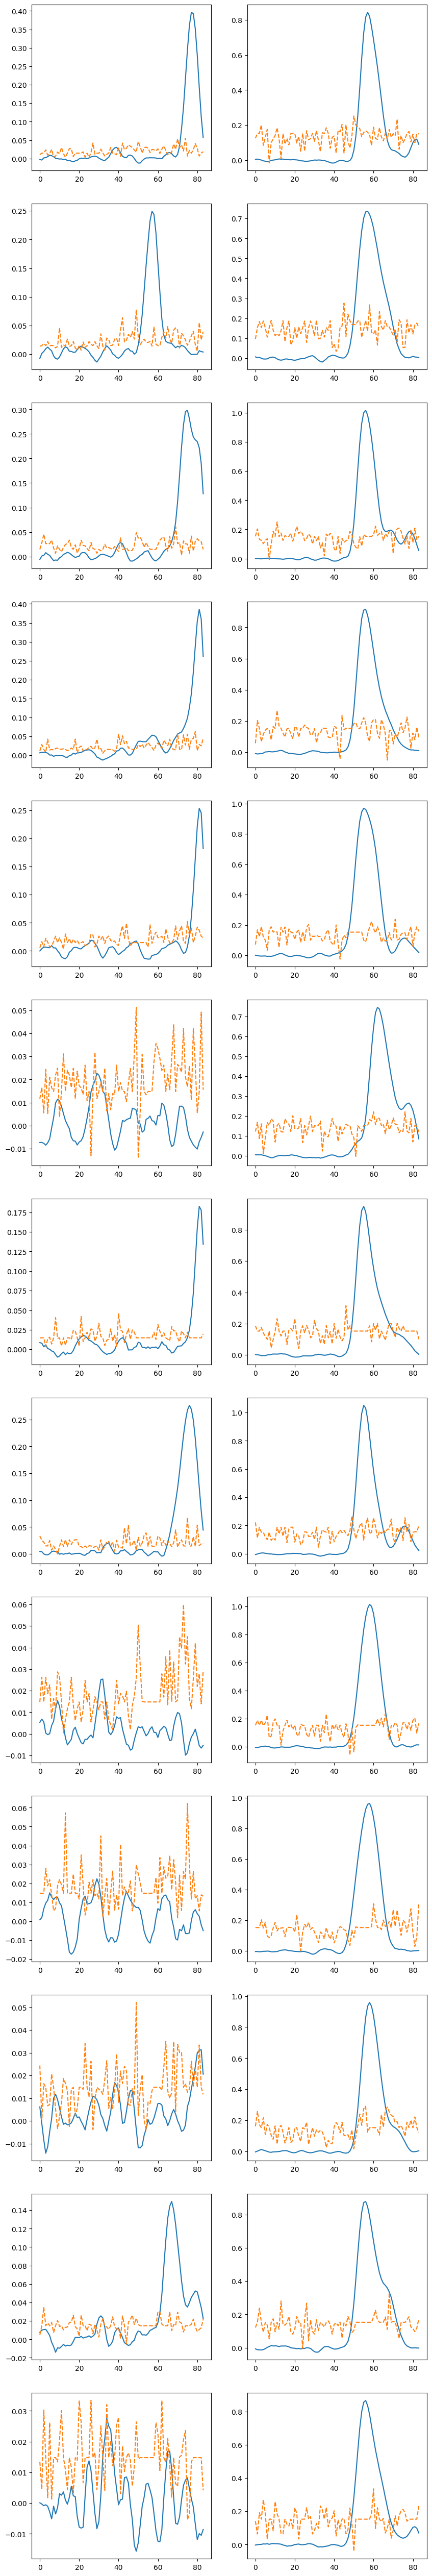

In [92]:
pred_vel = predictions.reshape(valid_behaviours.shape)
num_trials = valid_behaviours.shape[0]
fig, axs = plt.subplots(num_trials, 2, figsize=(10, num_trials*5))
for i in range(num_trials):
    for j in range(2):
        axs[i,j].plot(valid_behaviours[i, :, j])
        axs[i,j].plot(pred_vel[i, :, j], linestyle='--')    

lag 1 r2: 0.0010319809870230844
lag 2 r2: -0.0007973167172956152
lag 3 r2: 3.606140044700723e-05
lag 4 r2: -0.0006804734789090605
lag 5 r2: 0.0008899784080379058
lag 6 r2: 0.0022607142696171477
lag 7 r2: 0.003972424517739858
lag 8 r2: 0.004098454923091577
lag 9 r2: 0.004990830505469978
lag 10 r2: 0.001984724452920228
lag 11 r2: 0.003425282961955456
lag 12 r2: 0.0024424379094735603
lag 13 r2: 0.004346355315675043
lag 14 r2: 0.004819325570606203


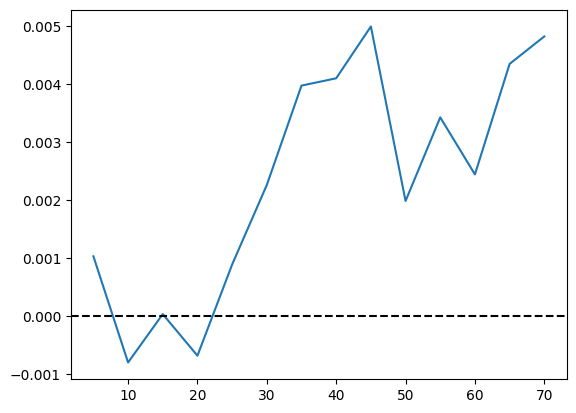

In [76]:
# try different lags
max_lag = 15
lags = np.arange(0, max_lag+1)
r2s = []
for lag in lags[1:-1]:
    r2 = []
    for cv in range(FOLDS):
        train_data[max_lag - lag:-lag], \
        valid_data[max_lag - lag:-lag], \
        train_behaviours[max_lag:], \
        valid_behaviours[max_lag:], _, _ = [v[max_lag:] for v in get_data_fold(cv)]

        # predict behavior from neural data using Ridge
        from sklearn.linear_model import Ridge

        ridge = Ridge(alpha=500)
        ridge.fit(train_data.reshape(-1,train_data.shape[-1]), train_behaviours.reshape(-1, 2))
        predictions = ridge.predict(valid_data.reshape(-1,valid_data.shape[-1]))

        # get a score
        r2.append(ridge.score(valid_data.reshape(-1,valid_data.shape[-1]),
                    valid_behaviours.reshape(-1, 2)))
    print(f'lag {lag} r2: {np.mean(r2)}')
    r2s.append(np.mean(r2))
plt.plot(5*lags[1:-1], r2s)
plt.axhline(0, color='k', linestyle='--')

# try an RNN decoder

In [98]:
import torch
from torch import nn

from lfads_torch.benchmark.biRNN_decoder import Decoder

In [178]:
def train_model(cv, target = 'res_vel', 
                FOLDS=5, start_bin=50, verbose=True, 
                **RNN_kwargs):

    train_data, valid_data, train_behaviours, valid_behaviours, train_mask, valid_mask = get_data_fold(cv, FOLDS=FOLDS, start_bin=start_bin)

    # train an RNN decoder to predict behavior from neural activity
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    N, M = train_data.shape[-1], train_behaviours.shape[-1] # number of neurons, number of behavior dimensions
    T = train_data.shape[1] # number of time bins
    assert M == 2, 'only 2D behavior is expected'
    print(f'Setup a model for cv Fold {cv+1}/{FOLDS}')
    rnn = Decoder(input_size=N, 
                rnn_size=64,
                hidden_size=64, 
                output_size=M, 
                seq_len=T, 
                num_layers=2,
                spike_dropout_rate = RNN_kwargs['spike_dropout_rate'],
                dropout = RNN_kwargs['dropout']).to(device)


    # Loss and optimizer
    loss = nn.MSELoss()
    # higher weight decay for RNN
    optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001, weight_decay=.01)

    #scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.9, verbose=verbose)

    # Convert numpy arrays to torch tensors
    inputs = torch.from_numpy(train_data.astype('float32')).to(device)
    test_inputs = torch.from_numpy(valid_data.astype('float32')).to(device)

    if target == 'res_vel':
        behaviors = torch.from_numpy(train_behaviours.astype('float32')).to(device)
        avg_vel = torch.mean(behaviors, axis=0).unsqueeze(0)
        behaviors = behaviors - avg_vel
    elif target == 'vel':    
        behaviors = torch.from_numpy(train_behaviours.astype('float32')).to(device)
    elif target == 'pos':
        behaviors = torch.cumsum(torch.from_numpy(train_behaviours.astype('float32')).to(device),axis=1)
    else:
        raise ValueError('target must be either "vel" or "pos"')
        
    test_vel = torch.from_numpy(valid_behaviours.astype('float32')).to(device)
    test_pos = torch.cumsum(test_vel,axis=1)

    # Train the model
    num_epochs = RNN_kwargs['num_epochs']
    batch_size = RNN_kwargs['batch_size']
    for epoch in range(num_epochs):

        batch_indices = list(range(inputs.shape[0]))
        batch = torch.from_numpy(np.random.choice(batch_indices, batch_size)).to(device)

        # print(batch)

        # Forward pass
        outputs = rnn(inputs[batch])
        cost = loss(outputs, behaviors[batch]) 

        # Backward and optimize
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        scheduler.step(cost)

        # print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {cost.item():.4f}, Test Loss: {test_cost.item():.4f}')
        # print epoch and R2
        if (epoch+1) % 10 == 0:
            # predict on test
            rnn.eval()
            train_outputs = rnn(inputs)
            train_cost = loss(train_outputs, behaviors) 
            test_outputs = rnn(test_inputs)
            if target == 'res_vel':
                test_cost = loss(test_outputs + avg_vel, test_vel)
            elif target == 'vel':
                test_cost = loss(test_outputs, test_vel)
            elif target == 'pos':
                test_cost = loss(test_outputs, test_pos)
            rnn.train()
            
            if target == 'res_vel':
                vel_R2 = r2_score(test_outputs + avg_vel, test_vel).item()
                pos_R2 = r2_score(torch.cumsum(test_outputs + avg_vel,axis=1), test_pos).item()
            elif target == 'vel':
                vel_R2 = r2_score(test_outputs, test_vel).item()
                pos_R2 = r2_score(torch.cumsum(test_outputs,axis=1), test_pos).item()
            elif target == 'pos':
                vel_R2 = r2_score(torch.diff(test_outputs, axis=1), test_vel[:,:-1]).item()
                pos_R2 = r2_score(test_outputs, test_pos).item()

            if verbose:
                print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_cost.item():.4f}, Test Loss: {test_cost.item():.4f}, \
                    vel_R2: {vel_R2:.4f}, \
                    pos_R2: {pos_R2:.4f},')
                
    if target == 'res_vel':
        test_outputs = test_outputs + avg_vel
            
    return pos_R2, vel_R2, test_outputs

In [240]:
# try on CV fold=0
RNN_kwargs = {
    'spike_dropout_rate': 0.2,
    'dropout': 0.2,
    'num_epochs': 500,
    'batch_size': 32,
}
pos_R2, vel_R2, test_outputs = train_model(0, target='pos', **RNN_kwargs)

Setup a model for cv Fold 1/5
Epoch [10/500], Loss: 11.8727, Test Loss: 11.9309,                     vel_R2: -0.2401,                     pos_R2: 0.0059,
Epoch [20/500], Loss: 11.2987, Test Loss: 11.3262,                     vel_R2: -0.2219,                     pos_R2: 0.0520,
Epoch [30/500], Loss: 9.8603, Test Loss: 9.7990,                     vel_R2: -0.2171,                     pos_R2: 0.1498,
Epoch [40/500], Loss: 6.9565, Test Loss: 6.8719,                     vel_R2: -0.1435,                     pos_R2: 0.3153,
Epoch [50/500], Loss: 4.7440, Test Loss: 4.7881,                     vel_R2: 0.1806,                     pos_R2: 0.4080,
Epoch [60/500], Loss: 3.4372, Test Loss: 3.4067,                     vel_R2: 0.2476,                     pos_R2: 0.4783,
Epoch [70/500], Loss: 2.5197, Test Loss: 2.4787,                     vel_R2: 0.2663,                     pos_R2: 0.5238,
Epoch [80/500], Loss: 1.9802, Test Loss: 1.9803,                     vel_R2: 0.3522,                     pos_R2: 0.

In [241]:
from plot_helpers import plot_beh_pred #, get_trials2plot

true_vel = valid_behaviours
true_pos = np.cumsum(true_vel, axis=1)
# pred_vel = test_outputs.cpu().detach().numpy()
# pred_pos = np.cumsum(pred_vel, axis=1)
# # trials2plot = get_trials2plot(true_pos, pred_pos, targets[valid_mask])
# trials2plot = np.ones(true_vel.shape[0])

pred_pos = test_outputs.cpu().detach().numpy()
pred_vel = np.diff(pred_pos, axis=1)
trials2plot = np.ones(true_vel.shape[0])

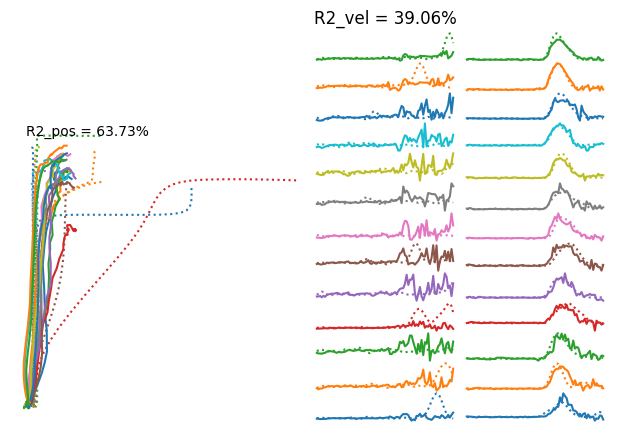

In [242]:
plot_beh_pred(true_vel[:,1:], pred_vel, np.arange(true_vel.shape[0]), trials2plot)

In [210]:
def get_CV_R2(target='vel', start_bin=50, FOLDS=5, verbose=True, **RNN_kwargs):
    cv_pos_R2, cv_vel_R2 = [], []
    for cv in range(FOLDS):
        pos_R2, vel_R2 = train_model(cv, target=target, FOLDS=FOLDS, start_bin=start_bin, verbose=False, **RNN_kwargs)
        if verbose:
            print(f'CV {cv}, pos_R2: {pos_R2:.4f}, vel_R2: {vel_R2:.4f}')
        cv_pos_R2.append(pos_R2)
        cv_vel_R2.append(vel_R2)
    print(f'CV pos_R2: {np.mean(cv_pos_R2):.4f} +/- {np.std(cv_pos_R2):.4f}')
    print(f'CV vel_R2: {np.mean(cv_vel_R2):.4f} +/- {np.std(cv_vel_R2):.4f}')
    return cv_pos_R2, cv_vel_R2

In [105]:
# test one set of hyperparameters
get_CV_R2(target='vel', verbose=True, spike_dropout_rate=0.2, dropout=0.5)

Setup a model for cv Fold 1/5
CV 0, pos_R2: 0.6336, vel_R2: 0.4531
Setup a model for cv Fold 2/5
CV 1, pos_R2: 0.6196, vel_R2: 0.4313
Setup a model for cv Fold 3/5
CV 2, pos_R2: 0.5200, vel_R2: 0.3700
Setup a model for cv Fold 4/5
CV 3, pos_R2: 0.5656, vel_R2: 0.5128
Setup a model for cv Fold 5/5
CV 4, pos_R2: 0.4735, vel_R2: 0.4910
CV pos_R2: 0.5625 +/- 0.0601
CV vel_R2: 0.4517 +/- 0.0497


([0.6336096525192261,
  0.6196457147598267,
  0.5200457572937012,
  0.5656408071517944,
  0.4734558165073395],
 [0.4531398117542267,
  0.4312988817691803,
  0.3700021505355835,
  0.5128017663955688,
  0.4910421371459961])

# run hyperparameter search

In [187]:
# use gridsearch to tune spike_dropout_rate and dropout
spike_dropout_rates = [0.2, 0.3]
dropouts = [0.2, 0.4, 0.6]
target = 'pos'
hyperparam_target = 'pos'

top_R2 = 0
best_params = {'spike_dropout_rate': None, 'dropout': None}
RNN_kwargs = {
    'num_epochs': 1500,
    'batch_size': 16,
}
for spike_dropout_rate in spike_dropout_rates:
    for dropout in dropouts:
        print(f'spike_dropout_rate: {spike_dropout_rate}, dropout: {dropout}')
        cv_pos_R2, cv_vel_R2 = get_CV_R2(target=target, verbose=False, spike_dropout_rate=spike_dropout_rate, dropout=dropout, **RNN_kwargs)
        # print(f'CV pos_R2: {np.mean(cv_pos_R2):.4f} +/- {np.std(cv_pos_R2):.4f}')
        # print(f'CV vel_R2: {np.mean(cv_vel_R2):.4f} +/- {np.std(cv_vel_R2):.4f}')
        if hyperparam_target == 'vel':
            mean_R2 = np.mean(cv_vel_R2)
        elif hyperparam_target == 'pos':
            mean_R2 = np.mean(cv_pos_R2)
        else:
            raise ValueError('hyperparam_target must be either "vel" or "pos"')
        if mean_R2 > top_R2:
            top_R2 = mean_R2
            best_params['spike_dropout_rate'] = spike_dropout_rate
            best_params['dropout'] = dropout

print(f'Top {hyperparam_target} R2: {top_R2:.4f}')
print(f'Best params: {best_params}')

spike_dropout_rate: 0.2, dropout: 0.2
Setup a model for cv Fold 1/5


KeyboardInterrupt: 